# Pseudolabels analysis with Pfam scores for *Escherichia coli* data

This notebook provides a preliminary analysis for pseudolabels determined for the 52 *E. coli* samples to be used for GraSSPlas project. 

## Obtaining pseudolabels

In this analysis, we focus on two types of pseudolabels: plasmid and chromosome. We have obtained the pseudolabels using two methods:
1) Using plasmid gene databases and contig lengths:</br> 
The databases required for plasmid pseudolabels were obtained manually by following the instructions on https://github.com/phac-nml/mob-suite on 14/05/2024. From the downloaded zipped file, we use four FASTA files. Each file contains a set of genes or proteins found in plasmids. The gene databases include replicon DNA sequences (rep.dna.fas) and origin of transfer DNA sequences (orit.dna.fas). The protein databases include the mobility proteins (mob.proteins.faa) and mate-pair formation proteins (mpf.proteins.faa). We use the Basic Local Alignment Search Tool (BLAST) to map the genes or proteins from these databases onto the short read contigs. If the contig is at least 500 bp and the quality of the mapping between the gene / protein and contig is high enough (0.8) and at least 60% of the gene / protein mapped to the contig, it is assigned the label plasmid.</br>
To assign the chromosome label, the mean ( 𝑚
 ) and standard deviation ( 𝑠𝑑
 ) of normalized read depths is obtained from the sample GFA files. If the contig has a length of at least 100000 bp and a read depth of at most  𝑚+2𝑠𝑑
 , the contig is labelled a chromosome.
 
2) Using Pfam scores: </br>
Pfam is a database of protein families (sets of regions with similar sequences; detected using hidden Markov models). We use the following database for generating pseudolabels: https://ftp.ncbi.nlm.nih.gov/pub/mmdb/cdd/little_endian/Pfam_LE.tar.gz </br>
We then use rpstblastn to search the database using a translated nucleotide query. Results from rpstblastn have then been scored using a model trained for ESKAPEE samples assembled using Unicycler. </br>
A contig with a score of over 0.5 is classified as a chromosome. An initial score of over 20 is used to classify a contig as a plasmid.    

In [1]:
import os
import pandas as pd
import networkx as nx
import statistics as stat
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
PLSNESS_DIR = '../data/plasmidness_0.6'
PSEUDOLABELS_DIR = '../data/Ecoli_Pseudolabels' #pseudolabels_060.tsv
PFAM_DIR = '../data/Ecoli_Pfam'
FEATURES_DIR = '../data/Ecoli_Features'
ASSEMBLY_DIR = '../data/Ecoli_AssemblyGraph_Filtered'
GROUNDTRUTH_DIR = '../data/Ecoli_GroundTruth'

In [3]:
def append_sample_id(df, sid):
    df['contig'] = sid+'_'+df['contig'].astype(str)
    return df

In [13]:
DF_LIST = []
for SID in os.listdir(ASSEMBLY_DIR):
    PFAM_DF = pd.read_csv(PFAM_DIR+'/'+SID+'_scores.tsv',sep='\t')
    PFAM_DF = append_sample_id(PFAM_DF, SID)
    FEATURE_DF = pd.read_csv(FEATURES_DIR+'/'+SID+'/features.tsv', sep='\t')
    FEATURE_DF = append_sample_id(FEATURE_DF, SID)
    PSEUDO_DF = pd.read_csv(PSEUDOLABELS_DIR+'/'+SID+'/pseudolabels_060.tsv', sep='\t')
    PSEUDO_DF = append_sample_id(PSEUDO_DF, SID)
    
    SAMPLE_DF = PSEUDO_DF.merge(FEATURE_DF, how='left', left_on='contig', right_on='contig')
    SAMPLE_DF = SAMPLE_DF.merge(PFAM_DF, how='left', left_on='contig', right_on='contig')
    
    DF_LIST.append(SAMPLE_DF)
OVERALL_DF = pd.concat(DF_LIST)
OVERALL_DF = OVERALL_DF.fillna(0)
OVERALL_DF.rename(columns={'chromosome_x':'pseudolabel_chr', 'plasmid_x':'pseudolabel_pls',\
                           'chromosome_y':'pfamscore_chr', 'plasmid_y':'pfamscore_pls'}, inplace=True)
OVERALL_DF['matepair']=0
OVERALL_DF['mobility']=0
OVERALL_DF['origintransfer']=0
OVERALL_DF['replicon']=0

OVERALL_DF['pfamlabel_chr'] = [1 if val >= 0.5 else 0 for val in OVERALL_DF['pfamscore_chr']]
OVERALL_DF['pfamlabel_pls'] = [1 if val >= 20 else 0 for val in OVERALL_DF['pfamscore_pls']]

OVERALL_DF['chromosome']=0
OVERALL_DF['plasmid']=0



In [14]:
def update_mob_mapping_cols(sid):
    for seq_type in ['matepair', 'mobility', 'origintransfer', 'replicon']:
        tmp_dict = {}
        file_size = os.path.getsize(PLSNESS_DIR+'/'+sid+'/'+seq_type+'_mapping.tsv')
        #print(SID, seq_type, file_size)
        if file_size != 0:
            mapping_df = pd.read_csv(PLSNESS_DIR+'/'+sid+'/'+seq_type+'_mapping.tsv', sep='\t', header=None)
            for index, row in mapping_df.iterrows():
                ctg, mapping = sid+'_'+str(row[0]), row[2]
                if ctg not in tmp_dict:
                    tmp_dict[ctg] = mapping
                else:
                    #print(ctg, seq_type, tmp_dict[ctg], mapping)
                    tmp_dict[ctg] = max(tmp_dict[ctg], mapping)
                
        for ctg in tmp_dict:
            OVERALL_DF.loc[OVERALL_DF['contig'] == ctg, seq_type] = tmp_dict[ctg]

In [15]:
def update_ground_truth(sid):
    gt_df = pd.read_csv(GROUNDTRUTH_DIR+'/'+sid+'/'+'ground_truth.tsv', sep='\t')
    gt_df = append_sample_id(gt_df, sid)
    pls_ctgs_set = set(gt_df['contig'].unique())
    OVERALL_DF.loc[OVERALL_DF['contig'].isin(pls_ctgs_set), 'plasmid'] = 1
    OVERALL_DF['chromosome'] = 1 - OVERALL_DF['plasmid']

In [16]:
for SID in os.listdir(ASSEMBLY_DIR):
    update_mob_mapping_cols(SID)
    update_ground_truth(SID)
    
    
OVERALL_DF

,contig,pseudolabel_chr,pseudolabel_pls,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,...,pfamscore_chr,pfamscore_pls,matepair,mobility,origintransfer,replicon,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
0,EC_E13DN_1_E_1,1,0,0,1,0.002880,0.998385,0,1,0.000,...,7.729964,-858.182742,0.0,0.0,0.0,0.0,1,0,1,0
1,EC_E13DN_1_E_2,1,0,0,1,0.004937,0.997082,0,1,0.000,...,5.022846,-626.258954,0.0,0.0,0.0,0.0,1,0,1,0
2,EC_E13DN_1_E_3,1,0,0,1,0.002322,0.998775,0,1,0.000,...,4.030824,-536.198099,0.0,0.0,0.0,0.0,1,0,1,0
3,EC_E13DN_1_E_4,1,0,0,1,0.003150,0.998164,0,1,0.000,...,5.965701,-597.478007,0.0,0.0,0.0,0.0,1,0,1,0
4,EC_E13DN_1_E_5,1,0,0,1,0.001870,0.998989,0,1,0.000,...,2.520178,-475.841409,0.0,0.0,0.0,0.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,EC_4957_C1_H_120,0,0,0,1,0.045530,0.989023,0,1,0.327,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,1,0
120,EC_4957_C1_H_121,0,0,0,1,0.067465,0.991426,0,1,0.334,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,1,0
121,EC_4957_C1_H_122,0,0,0,1,0.062800,0.993965,0,1,0.369,...,0.017397,-0.824064,0.0,0.0,0.0,0.0,0,0,1,0
122,EC_4957_C1_H_123,0,0,0,1,0.045506,0.989638,0,1,0.332,...,0.017397,-0.824064,0.0,0.0,0.0,0.0,0,0,1,0


In [17]:
OVERALL_DF[OVERALL_DF['plasmid'] == 1]

,contig,pseudolabel_chr,pseudolabel_pls,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,...,pfamscore_chr,pfamscore_pls,matepair,mobility,origintransfer,replicon,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
34,EC_E13DN_1_E_35,0,1,1,0,0.022076,0.986211,1,0,0.996,...,-41.958297,123.925294,1.0,1.00,1.0,1.0,0,1,0,1
37,EC_E13DN_1_E_38,0,1,1,0,0.120354,0.918541,1,0,0.971,...,-5.670347,27.864733,0.0,0.79,0.0,1.0,0,1,0,1
38,EC_E13DN_1_E_39,0,0,1,0,0.040309,0.976257,1,0,0.827,...,-2.293731,10.854302,0.0,0.00,0.0,0.0,0,0,0,1
42,EC_E13DN_1_E_43,0,0,0,1,0.117805,0.929068,1,0,0.714,...,-2.938504,14.875289,0.0,0.00,0.0,0.0,0,0,0,1
44,EC_E13DN_1_E_45,0,0,1,0,0.063221,0.958104,1,0,0.992,...,-1.130345,-0.817554,0.0,0.00,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,EC_4957_C1_H_67,0,0,0,1,0.059885,0.984872,0,1,0.293,...,-0.509952,2.623082,0.0,0.00,0.0,0.0,0,0,0,1
73,EC_4957_C1_H_74,0,0,1,0,0.098551,0.989437,0,1,0.303,...,-1.343661,5.624684,0.0,0.00,0.0,0.0,0,0,0,1
74,EC_4957_C1_H_75,0,0,1,0,0.022197,0.999302,0,1,0.438,...,-0.429570,2.498999,0.0,0.00,0.0,0.0,0,0,0,1
88,EC_4957_C1_H_89,0,0,1,0,0.094067,0.990900,0,1,0.613,...,-0.752135,2.885346,0.0,0.00,0.0,0.0,0,0,0,1


In [18]:
#Rearranging columns: 
#Contig name - Features - Mob db mapping scores - Pseudolabels - Pfam scores - Pfam labels - Ground truth
cols = OVERALL_DF.columns.tolist()
cols = cols[0:1] + cols[3:16] + cols[18:22] +  cols[1:3] + cols[16:18]  + cols[22:24] + cols[24:26]
OVERALL_DF = OVERALL_DF[cols]


In [19]:
OVERALL_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
0,EC_E13DN_1_E_1,0,1,0.002880,0.998385,0,1,0.000,1.000,0.016959,...,0.0,0.0,1,0,7.729964,-858.182742,1,0,1,0
1,EC_E13DN_1_E_2,0,1,0.004937,0.997082,0,1,0.000,1.000,0.022353,...,0.0,0.0,1,0,5.022846,-626.258954,1,0,1,0
2,EC_E13DN_1_E_3,0,1,0.002322,0.998775,0,1,0.000,1.000,0.032356,...,0.0,0.0,1,0,4.030824,-536.198099,1,0,1,0
3,EC_E13DN_1_E_4,0,1,0.003150,0.998164,0,1,0.000,1.000,0.021905,...,0.0,0.0,1,0,5.965701,-597.478007,1,0,1,0
4,EC_E13DN_1_E_5,0,1,0.001870,0.998989,0,1,0.000,1.000,0.039650,...,0.0,0.0,1,0,2.520178,-475.841409,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,EC_4957_C1_H_120,0,1,0.045530,0.989023,0,1,0.327,0.673,0.500000,...,0.0,0.0,0,0,0.000000,0.000000,0,0,1,0
120,EC_4957_C1_H_121,0,1,0.067465,0.991426,0,1,0.334,0.666,0.500000,...,0.0,0.0,0,0,0.000000,0.000000,0,0,1,0
121,EC_4957_C1_H_122,0,1,0.062800,0.993965,0,1,0.369,0.631,0.500000,...,0.0,0.0,0,0,0.017397,-0.824064,0,0,1,0
122,EC_4957_C1_H_123,0,1,0.045506,0.989638,0,1,0.332,0.668,0.500000,...,0.0,0.0,0,0,0.017397,-0.824064,0,0,1,0


In [20]:
#OVERALL_DF.to_csv('Ecoli_contig_details.tsv', sep='\t', index=False)

### Dataframe description

The final dataframe contains the information for 12176 contigs, spanning 52 samples. For each contig, we have:
1. contig (str): Contig name in the format Sample_Contig,
2. plasforest_pls (bin): Plasforest prediction if contig is plasmidic (1) or not (0), 
3. plasforest_chr (bin): Plasforest prediction if contig is chromosomal (1) or not (0), 
4. plasgraph2_pls (float): Plasgraph2 score if contig is plasmidic, 
5. plasgraph2_chr (float): Plasgraph2 score if contig is chromosomal, 
6. platon_pls (bin): Platon prediction if contig is plasmidic (1) or not (0), 
7. platon_chr (bin): Platon prediction if contig is chromosomal (1) or not (0), 
8. rfplasmid_pls (float): Rfplasmid score if contig is plasmidic, 
9. rfplasmid_chr (float): Rfplasmid score if contig is chromosomal,
10. mlplasmid_pls (float): Mlplasmid score if contig is plasmidic, 
11. mlplasmid_chr (float): Mlplasmid score if contig is chromosomal,
12. length (int): Length of contig,
13. read_depth (float):	Read depth of contig as provided by Unicycler,
14. gc_content (float): GC content of contig,
15. matepair (float): Maximum coverage of known matepair formation proteins by contig,
16. mobility (float): Maximum coverage of known mobility proteins by contig,
17. origintransfer (float): Maximum coverage of known origin of transfer genes by contig,
18. replicon (float): Maximum coverage of known replicon genes by contig,
19. pseudolabel_chr (bin): Chromosome pseudolabel assigned to contig, based on length and assembly read depth,
20. pseudolabel_pls (bin): Plasmid pseudolabel assigned to contig, based on maximum coverage threshold,
21. pfamscore_chr (float): Chromosome Pfam score for contig,
22. pfamscore_pls (float): Plasmid Pfam score for contig,
23. pfamscore_chr (float): Chromosome Pfam label assigned to contig,
24. pfamscore_pls (float): Plasmid Pfam label assigned to contig,
25. chromosome (bin): Ground truth classification if contig is chromosomal (1) or not (0), 
26. plasmid (bin): Ground truth classification if contig is plasmidic (1) or not (0),

### Basic analysis

#### Plasmid pseudolabels

In [22]:
PLS_DF = OVERALL_DF[OVERALL_DF['plasmid']==1]
min_len = PLS_DF['length'].min()
max_len = PLS_DF['length'].max()
mean_len = PLS_DF['length'].mean()
print("Number of plasmid contigs: ", PLS_DF.shape[0])
print("Minimum length of plasmid contigs: ", min_len)
print("Maximum length of plasmid contigs: ", max_len)
print("Average length of plasmid contigs: ", mean_len)

Number of plasmid contigs:  1676
Minimum length of plasmid contigs:  100
Maximum length of plasmid contigs:  100424
Average length of plasmid contigs:  5135.325775656324


<Axes: >

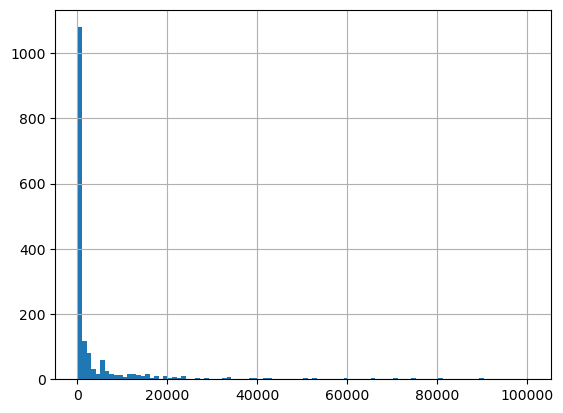

In [36]:
PLS_DF['length'].hist(bins=100)

In [24]:
PLS_PSEUDO_DF = OVERALL_DF[OVERALL_DF['pseudolabel_pls']==1]
min_len = PLS_PSEUDO_DF['length'].min()
max_len = PLS_PSEUDO_DF['length'].max()
mean_len = PLS_PSEUDO_DF['length'].mean()
print("Number of plasmid pseudolabel contigs: ", PLS_PSEUDO_DF.shape[0])
print("Minimum length of plasmid pseudolabel contigs: ", min_len)
print("Maximum length of plasmid pseudolabel contigs: ", max_len)
print("Average length of plasmid pseudolabel contigs: ", mean_len)

Number of plasmid pseudolabel contigs:  258
Minimum length of plasmid pseudolabel contigs:  238
Maximum length of plasmid pseudolabel contigs:  387486
Average length of plasmid pseudolabel contigs:  29690.98449612403


In [39]:
PLS_PSEUDO_DF[PLS_PSEUDO_DF['length'] <= 1000]

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
198,EC_9619_1H1_D_199,1,0,0.757166,0.935891,0,1,0.481,0.519,0.5,...,0.0,0.0,0,1,-1.439857,7.736429,0,0,0,1
187,EC_0731_1H1_D_188,1,0,0.999989,0.008517,0,1,0.402,0.598,0.5,...,0.0,0.8,0,1,0.000000,0.000000,0,0,0,1
142,EC_E13FP_1_E_143,1,0,0.916671,0.862532,0,1,0.545,0.455,0.5,...,0.0,0.0,0,1,-1.439857,7.736429,0,0,0,1
112,EC_0205_C4_H_113,1,0,0.780243,0.961032,0,1,0.481,0.519,0.5,...,0.0,0.0,0,1,-1.439857,7.736429,0,0,0,1
163,EC_9226_C5_H_164,1,0,0.889136,0.237608,0,1,0.284,0.716,0.5,...,0.0,0.0,0,1,-1.458615,3.240573,0,0,0,1
164,EC_9226_C5_H_165,1,0,0.823184,0.326257,0,1,0.327,0.673,0.5,...,0.0,0.0,0,1,-1.458615,3.240573,0,0,0,1
168,EC_9226_C5_H_169,1,0,0.849232,0.395271,0,1,0.339,0.661,0.5,...,0.0,0.0,0,1,-1.458615,3.240573,0,0,0,1
204,EC_9226_C5_H_205,1,0,0.745692,0.426762,0,1,0.377,0.623,0.5,...,0.0,0.0,0,1,-1.435085,3.233616,0,0,0,1
205,EC_9226_C5_H_206,1,0,0.815500,0.358719,0,1,0.353,0.647,0.5,...,0.0,0.0,0,1,-1.435085,3.233616,0,0,0,1


In [25]:
PLS_PFAM_DF = OVERALL_DF[OVERALL_DF['pfamlabel_pls']==1]
min_len = PLS_PFAM_DF['length'].min()
max_len = PLS_PFAM_DF['length'].max()
mean_len = PLS_PFAM_DF['length'].mean()
print("Number of plasmid Pfam pseudolabel contigs: ", PLS_PFAM_DF.shape[0])
print("Minimum length of plasmid Pfam pseudolabel contigs: ", min_len)
print("Maximum length of plasmid Pfam pseudolabel contigs: ", max_len)
print("Average length of plasmid Pfam pseudolabel contigs: ", mean_len)

Number of plasmid Pfam pseudolabel contigs:  219
Minimum length of plasmid Pfam pseudolabel contigs:  1420
Maximum length of plasmid Pfam pseudolabel contigs:  100424
Average length of plasmid Pfam pseudolabel contigs:  30308.328767123287


In [26]:
PLS_COMMON_PSEUDO_DF = OVERALL_DF[(OVERALL_DF['pseudolabel_pls']==1) & (OVERALL_DF['pfamlabel_pls']==1)]
PLS_COMMON_PSEUDO_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
34,EC_E13DN_1_E_35,1,0,0.022076,0.986211,1,0,0.996,0.004,0.812944,...,1.00,1.0,0,1,-41.958297,123.925294,0,1,0,1
37,EC_E13DN_1_E_38,1,0,0.120354,0.918541,1,0,0.971,0.029,0.664522,...,0.00,1.0,0,1,-5.670347,27.864733,0,1,0,1
18,EC_0038_3S2_D_19,1,0,0.028226,0.981991,1,0,0.995,0.005,0.720120,...,1.00,1.0,0,1,-59.757081,191.290755,0,1,0,1
31,EC_0038_3S2_D_32,1,0,0.110139,0.928455,1,0,0.972,0.028,0.620502,...,0.00,1.0,0,1,-6.141899,30.431692,0,1,0,1
16,EC_0205_3S1_D_17,0,1,0.424604,0.717281,1,0,0.869,0.131,0.715172,...,0.00,1.0,0,1,-4.280507,33.450379,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,EC_4957_C6_H_25,1,0,0.682284,0.452995,1,0,0.947,0.053,0.728040,...,1.00,1.0,0,1,-52.344912,159.240817,0,1,0,1
35,EC_0012_C1_H_36,1,0,0.812050,0.297629,1,0,0.891,0.109,0.663904,...,0.00,1.0,0,1,-32.910546,98.419903,0,1,0,1
64,EC_0012_C1_H_65,1,0,0.914659,0.159770,1,0,0.748,0.252,0.904711,...,1.00,0.0,0,1,-13.837293,38.558133,0,1,0,1
76,EC_0012_C1_H_77,0,1,0.999895,0.004028,1,0,0.884,0.116,0.931584,...,1.00,1.0,0,1,-5.437166,20.197693,0,1,0,1


In [28]:
PLS_CORRECT_PSEUDO_DF = OVERALL_DF[(OVERALL_DF['pseudolabel_pls']==1) & (OVERALL_DF['plasmid']==1)]
PLS_CORRECT_PSEUDO_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
34,EC_E13DN_1_E_35,1,0,0.022076,0.986211,1,0,0.996,0.004,0.812944,...,1.00,1.00,0,1,-41.958297,123.925294,0,1,0,1
37,EC_E13DN_1_E_38,1,0,0.120354,0.918541,1,0,0.971,0.029,0.664522,...,0.00,1.00,0,1,-5.670347,27.864733,0,1,0,1
47,EC_E13DN_1_E_48,1,0,0.102361,0.937483,1,0,0.658,0.342,0.652161,...,0.00,1.00,0,1,-2.157259,10.930598,0,0,0,1
18,EC_0038_3S2_D_19,1,0,0.028226,0.981991,1,0,0.995,0.005,0.720120,...,1.00,1.00,0,1,-59.757081,191.290755,0,1,0,1
31,EC_0038_3S2_D_32,1,0,0.110139,0.928455,1,0,0.972,0.028,0.620502,...,0.00,1.00,0,1,-6.141899,30.431692,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,EC_0012_C1_H_77,0,1,0.999895,0.004028,1,0,0.884,0.116,0.931584,...,1.00,1.00,0,1,-5.437166,20.197693,0,1,0,1
98,EC_0012_C1_H_99,0,1,0.999953,0.005581,0,1,0.626,0.374,0.202310,...,0.00,1.00,0,1,0.000000,0.000000,0,0,0,1
99,EC_0012_C1_H_100,0,1,0.999891,0.008542,1,0,0.968,0.032,0.701972,...,0.00,0.88,0,1,-1.730204,5.942914,0,0,0,1
20,EC_4957_C1_H_21,1,0,0.009155,0.995040,1,0,1.000,0.000,0.894939,...,0.86,1.00,0,1,-64.504900,218.267013,0,1,0,1


In [29]:
PLS_CORRECT_PFAM_DF = OVERALL_DF[(OVERALL_DF['plasmid']==1) & (OVERALL_DF['pfamlabel_pls']==1)]
PLS_CORRECT_PFAM_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
34,EC_E13DN_1_E_35,1,0,0.022076,0.986211,1,0,0.996,0.004,0.812944,...,1.00,1.0,0,1,-41.958297,123.925294,0,1,0,1
37,EC_E13DN_1_E_38,1,0,0.120354,0.918541,1,0,0.971,0.029,0.664522,...,0.00,1.0,0,1,-5.670347,27.864733,0,1,0,1
45,EC_E13DN_1_E_46,0,1,0.164277,0.899582,1,0,0.585,0.415,0.225043,...,0.00,0.0,0,0,-4.368336,27.021015,0,1,0,1
18,EC_0038_3S2_D_19,1,0,0.028226,0.981991,1,0,0.995,0.005,0.720120,...,1.00,1.0,0,1,-59.757081,191.290755,0,1,0,1
31,EC_0038_3S2_D_32,1,0,0.110139,0.928455,1,0,0.972,0.028,0.620502,...,0.00,1.0,0,1,-6.141899,30.431692,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,EC_0012_C1_H_36,1,0,0.812050,0.297629,1,0,0.891,0.109,0.663904,...,0.00,1.0,0,1,-32.910546,98.419903,0,1,0,1
60,EC_0012_C1_H_61,0,1,0.275079,0.855129,1,0,0.883,0.117,0.935134,...,0.00,0.0,0,0,-7.602624,40.295858,0,1,0,1
64,EC_0012_C1_H_65,1,0,0.914659,0.159770,1,0,0.748,0.252,0.904711,...,1.00,0.0,0,1,-13.837293,38.558133,0,1,0,1
76,EC_0012_C1_H_77,0,1,0.999895,0.004028,1,0,0.884,0.116,0.931584,...,1.00,1.0,0,1,-5.437166,20.197693,0,1,0,1


In [42]:
PLS_CORRECT_BOTH_DF = OVERALL_DF[(OVERALL_DF['plasmid']==1) & (OVERALL_DF['pfamlabel_pls']==1) & (OVERALL_DF['pseudolabel_pls']==1)]
PLS_CORRECT_BOTH_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
34,EC_E13DN_1_E_35,1,0,0.022076,0.986211,1,0,0.996,0.004,0.812944,...,1.00,1.0,0,1,-41.958297,123.925294,0,1,0,1
37,EC_E13DN_1_E_38,1,0,0.120354,0.918541,1,0,0.971,0.029,0.664522,...,0.00,1.0,0,1,-5.670347,27.864733,0,1,0,1
18,EC_0038_3S2_D_19,1,0,0.028226,0.981991,1,0,0.995,0.005,0.720120,...,1.00,1.0,0,1,-59.757081,191.290755,0,1,0,1
31,EC_0038_3S2_D_32,1,0,0.110139,0.928455,1,0,0.972,0.028,0.620502,...,0.00,1.0,0,1,-6.141899,30.431692,0,1,0,1
16,EC_0205_3S1_D_17,0,1,0.424604,0.717281,1,0,0.869,0.131,0.715172,...,0.00,1.0,0,1,-4.280507,33.450379,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,EC_4957_C6_H_25,1,0,0.682284,0.452995,1,0,0.947,0.053,0.728040,...,1.00,1.0,0,1,-52.344912,159.240817,0,1,0,1
35,EC_0012_C1_H_36,1,0,0.812050,0.297629,1,0,0.891,0.109,0.663904,...,0.00,1.0,0,1,-32.910546,98.419903,0,1,0,1
64,EC_0012_C1_H_65,1,0,0.914659,0.159770,1,0,0.748,0.252,0.904711,...,1.00,0.0,0,1,-13.837293,38.558133,0,1,0,1
76,EC_0012_C1_H_77,0,1,0.999895,0.004028,1,0,0.884,0.116,0.931584,...,1.00,1.0,0,1,-5.437166,20.197693,0,1,0,1


The above analysis suggests that both types of pseudolabels leave out shorter contigs. In total, there are 1676 contigs mapped to plasmids. Over a 1000 of these contigs are less than 1000 bp in length. Only 9 out of 258 contigs with MOB-based plasmid pseudolabels are shorter than 1000 bp while none of the 219 Pfam generated labels are shorter than 1000 bp.

Interestingly, only 123 contigs are common both sets of plasmid pseudolabels. 241 out of 258 contigs with MOB-based pseudolabels are correct according to the ground truth while only 152 out of 219 contigs with Pfam based pseudolabels are correct. 

#### Chromosome pseudolabels

In [30]:
CHR_DF = OVERALL_DF[OVERALL_DF['chromosome']==1]
min_len = CHR_DF['length'].min()
max_len = CHR_DF['length'].max()
mean_len = CHR_DF['length'].mean()
print("Number of chromosome contigs: ", CHR_DF.shape[0])
print("Minimum length of chromosome contigs: ", min_len)
print("Maximum length of chromosome contigs: ", max_len)
print("Average length of chromosome contigs: ", mean_len)

Number of chromosome contigs:  10500
Minimum length of chromosome contigs:  100
Maximum length of chromosome contigs:  790743
Average length of chromosome contigs:  24465.995142857144


In [31]:
CHR_PSEUDO_DF = OVERALL_DF[OVERALL_DF['pseudolabel_chr']==1]
min_len = CHR_PSEUDO_DF['length'].min()
max_len = CHR_PSEUDO_DF['length'].max()
mean_len = CHR_PSEUDO_DF['length'].mean()
print("Number of chromosome pseudolabel contigs: ", CHR_PSEUDO_DF.shape[0])
print("Minimum length of chromosome pseudolabel contigs: ", min_len)
print("Maximum length of chromosome pseudolabel contigs: ", max_len)
print("Average length of chromosome pseudolabel contigs: ", mean_len)

Number of chromosome pseudolabel contigs:  851
Minimum length of chromosome pseudolabel contigs:  100424
Maximum length of chromosome pseudolabel contigs:  790743
Average length of chromosome pseudolabel contigs:  211516.42303172738


In [32]:
CHR_PFAM_DF = OVERALL_DF[OVERALL_DF['pfamlabel_chr']==1]
min_len = CHR_PFAM_DF['length'].min()
max_len = CHR_PFAM_DF['length'].max()
mean_len = CHR_PFAM_DF['length'].mean()
print("Number of chromosome Pfam pseudolabel contigs: ", CHR_PFAM_DF.shape[0])
print("Minimum length of chromosome Pfam pseudolabel contigs: ", min_len)
print("Maximum length of chromosome Pfam pseudolabel contigs: ", max_len)
print("Average length of chromosome Pfam pseudolabel contigs: ", mean_len)

Number of chromosome Pfam pseudolabel contigs:  1359
Minimum length of chromosome Pfam pseudolabel contigs:  459
Maximum length of chromosome Pfam pseudolabel contigs:  790743
Average length of chromosome Pfam pseudolabel contigs:  143237.91096394407


In [27]:
CHR_COMMON_PSEUDO_DF = OVERALL_DF[(OVERALL_DF['pseudolabel_chr']==1) & (OVERALL_DF['pfamlabel_chr']==1)]
CHR_COMMON_PSEUDO_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
0,EC_E13DN_1_E_1,0,1,0.002880,0.998385,0,1,0.0,1.0,0.016959,...,0.0,0.0,1,0,7.729964,-858.182742,1,0,1,0
1,EC_E13DN_1_E_2,0,1,0.004937,0.997082,0,1,0.0,1.0,0.022353,...,0.0,0.0,1,0,5.022846,-626.258954,1,0,1,0
2,EC_E13DN_1_E_3,0,1,0.002322,0.998775,0,1,0.0,1.0,0.032356,...,0.0,0.0,1,0,4.030824,-536.198099,1,0,1,0
3,EC_E13DN_1_E_4,0,1,0.003150,0.998164,0,1,0.0,1.0,0.021905,...,0.0,0.0,1,0,5.965701,-597.478007,1,0,1,0
4,EC_E13DN_1_E_5,0,1,0.001870,0.998989,0,1,0.0,1.0,0.039650,...,0.0,0.0,1,0,2.520178,-475.841409,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,EC_4957_C1_H_13,0,1,0.002976,0.998422,0,1,0.0,1.0,0.026085,...,0.0,0.0,1,0,2.045151,-256.569210,1,0,1,0
13,EC_4957_C1_H_14,0,1,0.003854,0.997903,0,1,0.0,1.0,0.050064,...,0.0,0.0,1,0,2.668886,-294.487710,1,0,1,0
14,EC_4957_C1_H_15,0,1,0.010728,0.994095,0,1,0.0,1.0,0.023643,...,0.0,0.0,1,0,1.355706,-224.471878,1,0,1,0
15,EC_4957_C1_H_16,0,1,0.004260,0.997718,0,1,0.0,1.0,0.039954,...,0.0,0.0,1,0,2.987050,-245.952063,1,0,1,0


In [33]:
CHR_CORRECT_PSEUDO_DF = OVERALL_DF[(OVERALL_DF['pseudolabel_chr']==1) & (OVERALL_DF['chromosome']==1)]
CHR_CORRECT_PSEUDO_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
0,EC_E13DN_1_E_1,0,1,0.002880,0.998385,0,1,0.000,1.000,0.016959,...,0.0,0.0,1,0,7.729964,-858.182742,1,0,1,0
1,EC_E13DN_1_E_2,0,1,0.004937,0.997082,0,1,0.000,1.000,0.022353,...,0.0,0.0,1,0,5.022846,-626.258954,1,0,1,0
2,EC_E13DN_1_E_3,0,1,0.002322,0.998775,0,1,0.000,1.000,0.032356,...,0.0,0.0,1,0,4.030824,-536.198099,1,0,1,0
3,EC_E13DN_1_E_4,0,1,0.003150,0.998164,0,1,0.000,1.000,0.021905,...,0.0,0.0,1,0,5.965701,-597.478007,1,0,1,0
4,EC_E13DN_1_E_5,0,1,0.001870,0.998989,0,1,0.000,1.000,0.039650,...,0.0,0.0,1,0,2.520178,-475.841409,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,EC_4957_C1_H_14,0,1,0.003854,0.997903,0,1,0.000,1.000,0.050064,...,0.0,0.0,1,0,2.668886,-294.487710,1,0,1,0
14,EC_4957_C1_H_15,0,1,0.010728,0.994095,0,1,0.000,1.000,0.023643,...,0.0,0.0,1,0,1.355706,-224.471878,1,0,1,0
15,EC_4957_C1_H_16,0,1,0.004260,0.997718,0,1,0.000,1.000,0.039954,...,0.0,0.0,1,0,2.987050,-245.952063,1,0,1,0
16,EC_4957_C1_H_17,0,1,0.005106,0.997201,0,1,0.000,1.000,0.022014,...,0.0,0.0,1,0,2.003790,-178.599756,1,0,1,0


In [34]:
CHR_CORRECT_PFAM_DF = OVERALL_DF[(OVERALL_DF['chromosome']==1) & (OVERALL_DF['pfamlabel_chr']==1)]
CHR_CORRECT_PFAM_DF

,contig,plasforest_pls,plasforest_chr,plasgraph2_pls,plasgraph2_chr,platon_pls,platon_chr,rfplasmid_pls,rfplasmid_chr,mlplasmid_pls,...,origintransfer,replicon,pseudolabel_chr,pseudolabel_pls,pfamscore_chr,pfamscore_pls,pfamlabel_chr,pfamlabel_pls,chromosome,plasmid
0,EC_E13DN_1_E_1,0,1,0.002880,0.998385,0,1,0.000,1.000,0.016959,...,0.0,0.0,1,0,7.729964,-858.182742,1,0,1,0
1,EC_E13DN_1_E_2,0,1,0.004937,0.997082,0,1,0.000,1.000,0.022353,...,0.0,0.0,1,0,5.022846,-626.258954,1,0,1,0
2,EC_E13DN_1_E_3,0,1,0.002322,0.998775,0,1,0.000,1.000,0.032356,...,0.0,0.0,1,0,4.030824,-536.198099,1,0,1,0
3,EC_E13DN_1_E_4,0,1,0.003150,0.998164,0,1,0.000,1.000,0.021905,...,0.0,0.0,1,0,5.965701,-597.478007,1,0,1,0
4,EC_E13DN_1_E_5,0,1,0.001870,0.998989,0,1,0.000,1.000,0.039650,...,0.0,0.0,1,0,2.520178,-475.841409,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,EC_4957_C1_H_28,0,1,0.007937,0.995677,0,1,0.000,1.000,0.017623,...,0.0,0.0,0,0,1.396256,-123.717902,1,0,1,0
33,EC_4957_C1_H_34,0,1,0.013028,0.992863,0,1,0.000,1.000,0.098686,...,0.0,0.0,0,0,1.020882,-77.590823,1,0,1,0
34,EC_4957_C1_H_35,0,1,0.016350,0.990901,0,1,0.008,0.992,0.088652,...,0.0,0.0,0,0,1.404101,-121.198759,1,0,1,0
36,EC_4957_C1_H_37,0,1,0.016320,0.990450,0,1,0.011,0.989,0.045624,...,0.0,0.0,0,0,0.594571,-53.994261,1,0,1,0


For chromosomal contigs, 851 contigs are assigned chromosome pseudolabels according to their lengths. 850 out of these are correct according to the ground truth. All 1359 contigs with Pfam based chromosome pseudolabels are correct. 750 contigs appear in both sets of chromosome pseudolabels.

### Neighbourhood analysis

In [43]:
G = nx.Graph()
count = 0
for SID in os.listdir(ASSEMBLY_DIR):
    count += 1
    ASSEM_PATH = ASSEMBLY_DIR + '/' + SID
    if os.path.isdir(ASSEM_PATH):
        ASSEM_FILE = ASSEM_PATH + '/short_read_filtered.gfa'
        f = open(ASSEM_FILE, "r")
        for line in f.readlines():
            line = line.split('\t')
            if line[0] == 'S':
                ctg_id = line[1]
                G.add_node(SID + '_' + ctg_id)
            if line[0] == 'L':
                ctg_1, ctg_2 = line[1], line[3]
                G.add_edge(SID + '_' + ctg_1, SID + '_' + ctg_2)

In [44]:
print("Total number of edges: ", G.number_of_edges())

Total number of edges:  25347


In [45]:
print("Total number of contigs: ", G.number_of_nodes())

Total number of contigs:  12176


In [46]:
def record_dist(labels_set):
    dist_list = []
    for ctg_1 in labels_set:
        for ctg_2 in labels_set:
            sid_1, sid_2 = ctg_1.split('_')[:-1], ctg_2.split('_')[:-1]
            if ctg_1 != ctg_2 and sid_1 == sid_2:
                try:
                    n=nx.shortest_path_length(G, source=ctg_1, target=ctg_2)
                    dist_list.append(n)
                except nx.NetworkXNoPath:
                    continue       
    return dist_list

In [47]:
PLS_PSEUDO_SET = set(PLS_PSEUDO_DF['contig'].to_list())
CHR_PSEUDO_SET = set(CHR_PSEUDO_DF['contig'].to_list())
pls_dist_list = record_dist(PLS_PSEUDO_SET)
chr_dist_list = record_dist(CHR_PSEUDO_SET)

In [48]:
print("Pairs of plasmid pseudolabels connected to each other: ", len(pls_dist_list))
print("Pairs of chromosome pseudolabels connected to each other: ", len(chr_dist_list))

Pairs of plasmid pseudolabels connected to each other:  784
Pairs of chromosome pseudolabels connected to each other:  13202


In [49]:
print("Average distance between two connected plasmid pseudolabels: ", stat.mean(pls_dist_list))
print("Average distance between two connected chromosome pseudolabels: ", stat.mean(chr_dist_list))

Average distance between two connected plasmid pseudolabels:  6.6938775510204085
Average distance between two connected chromosome pseudolabels:  4.055294652325405


In [50]:
PLS_PFAM_SET = set(PLS_PFAM_DF['contig'].to_list())
CHR_PFAM_SET = set(CHR_PFAM_DF['contig'].to_list())
pls_dist_list = record_dist(PLS_PFAM_SET)
chr_dist_list = record_dist(CHR_PFAM_SET)

In [51]:
print("Pairs of plasmid pfamlabels connected to each other: ", len(pls_dist_list))
print("Pairs of chromosome pfamlabels connected to each other: ", len(chr_dist_list))

Pairs of plasmid pfamlabels connected to each other:  796
Pairs of chromosome pfamlabels connected to each other:  35460


In [52]:
print("Average distance between two connected plasmid pfamlabels: ", stat.mean(pls_dist_list))
print("Average distance between two connected chromosome pfamlabels: ", stat.mean(chr_dist_list))

Average distance between two connected plasmid pfamlabels:  4.668341708542713
Average distance between two connected chromosome pfamlabels:  3.7874788494077833


In general, this suggests that the MOB-databases are more reliable for plasmid pseudolabels while the Pfam databases offer more chromosome pseudolabels. Hence, there is a case for exploring the use of both sets of pseudolabels together. However, we then might end up introducing some false positives in the plasmid pseudolabels. On the other hand, pseudolabels generated by Pfam scores are better connected in the assembly graph than the MOB/length based pseudolabels.
